<a href="https://colab.research.google.com/github/bomiiisong/DeepLearning-with-Python/blob/master/Vanilla_GAN_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla GAN(Generative Adversarial Network)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

> ## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU

## I. Load MNIST Dataset
* 'generator'의 'tanh' Activation 출력에 적합하도록 정규화

In [ ]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Nomalization
X_train = X_train.astype(np.float32) / 127.5 - 1

# Reshape
X_train = X_train.reshape(60000, 784)

11493376/11490434 [==============================] - 0s 0us/step


## II. 'adam' Optimizer
* beta_1 : 감쇠율 조정

In [ ]:
from keras.optimizers import Adam

adam = Adam(lr=0.0002, beta_1=0.5)

## III. 'generator' Model
* 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력받아 이미지 생성
    * NOISE_DIM : 입력 랜덤 벡터 크기
* 'discriminator'를 속이도록 학습
    * 'Real Image'와 같은 'Fake Image' 생성이 목적

In [ ]:
NOISE_DIM = 10

generator = Sequential(name='generator')

generator.add(Dense(256, input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU())
generator.add(Dense(512))
generator.add(LeakyReLU())
generator.add(Dense(1024))
generator.add(LeakyReLU())
generator.add(Dense(784, activation='tanh'))

* 생성 모델 Summary

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2816      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 784)               80

## IV. 'discriminator' Model
* 이미지를 입력받아 'Real Image'인지 'generator'가 생성한 'Fake Image' 인지 판별
    * 이진분류 ( Real or Not)

In [ ]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name='discriminator')

discriminator.add(Dense(1024, input_shape=(784,),
                        kernel_initializer=RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation='sigmoid'))

* 판별 모델 Summary

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)             

> ### 1) 'discriminator' Compile

In [ ]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=adam)

## V. 'gan' Model

> ### 1) 'generator', 'discriminator' 연결

* 'gan' 모델에서 'generator'만 학습하도록 설정
    * discriminator.trainable = False


In [ ]:
discriminator.trainable = False

gan_input = Input(shape=(NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

> ### 2) 'gan' Model

In [ ]:
gan = Model(gan_input, output, name='gan')

### 3) 'gan' Summary

In [ ]:
gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 784)               1463312   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


> ### 4) 'gan' Compile

In [ ]:
gan.compile(loss='binary_crossentropy',
            optimizer=adam)

## VI. Define 'get_batches( )' Function
* MNIST image batch 생성

In [ ]:
def get_batches(data, batch_size):
    batches = []

    for i in range(data.shape[0] // batch_size):
        batch = data[i * batch_size : (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

## VII. 'visualize_training( )' Function

In [ ]:
def visualize_training(epoch, d_losses, g_losses):

    # 오차 시각화
    plt.figure(figsize=(8,4))
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses), np.asarray(g_losses)))

    # 이미지 생성 결과
    print('epoch : ', epoch)
    noise = np.random.normal(0, 1, size=(24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)

    plt.figure(figsize=(8,4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout
    plt.show()

## VIII. Model Training

* 약 35분 소요
* .fit()
    * 'epoch', 'batch_size' 지정
* .train_on_batch( )
    * 전달 받은 모든 데이터를 사용하여 학습 진행
* 'generator'가 매번 새로운 'Fake Image'를 생성하여 '.train_on_batch( )' 사용

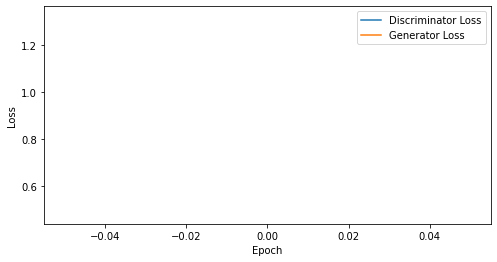

epoch: 1, Discriminator Loss: [0.48182121], Generator Loss: [1.32443953]
epoch :  1


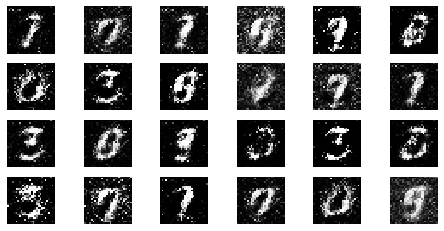

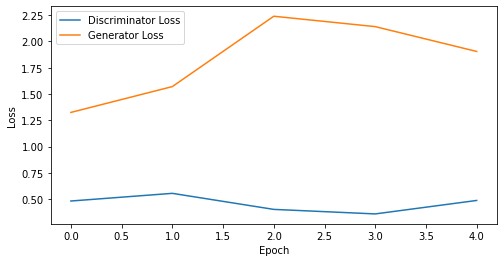

epoch: 5, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928]
epoch :  5


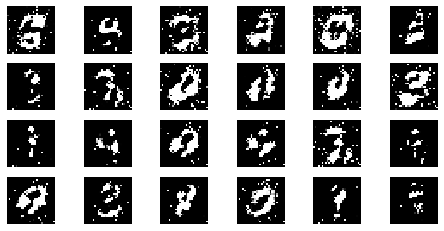

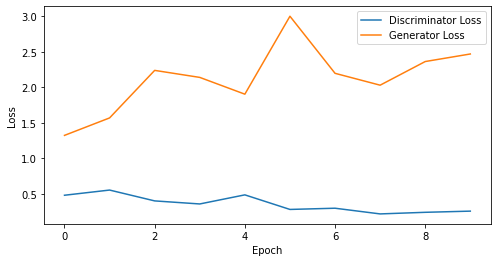

epoch: 10, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611 ]
epoch :  10


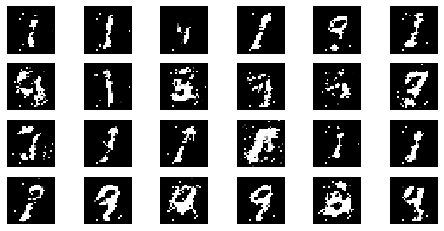

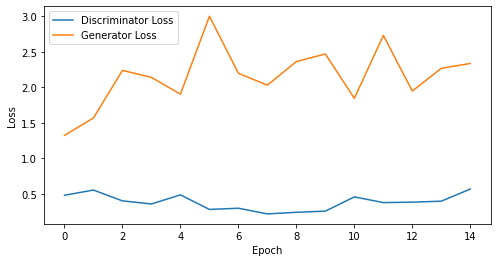

epoch: 15, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975]
epoch :  15


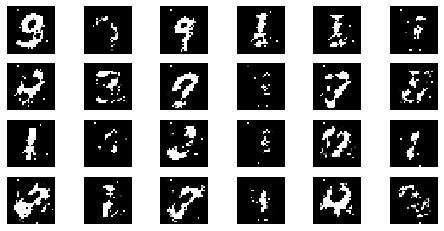

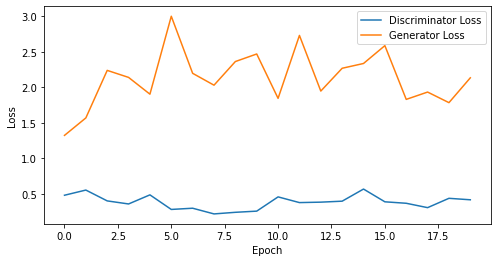

epoch: 20, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2.58772326 1.83111584 1.93426311
 1.78512692 2.13469982]
epoch :  20


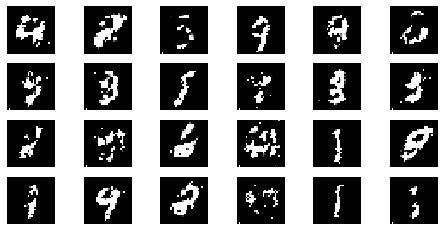

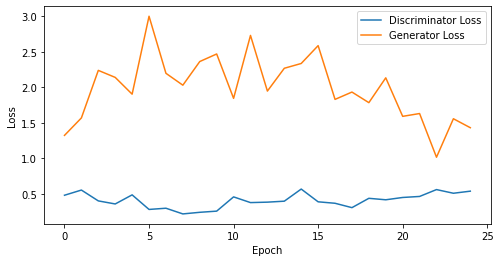

epoch: 25, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2.58772326 1.83111584 1.93426311
 1.78512692 2.13469982 1.59241939 1.63200712 1.01684582 1.55866873
 1.43240595]
epoch :  25


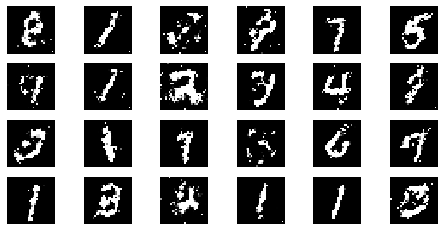

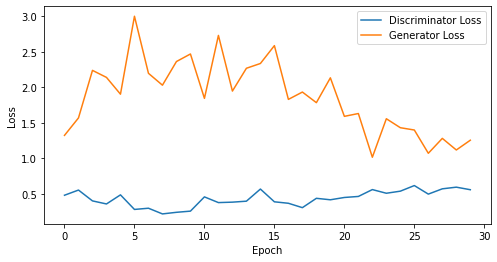

epoch: 30, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2.58772326 1.83111584 1.93426311
 1.78512692 2.13469982 1.59241939 1.63200712 1.01684582 1.55866873
 1.43240595 1.40002942 1.07261205 1.28229523 1.11896157 1.25640666]
epoch :  30


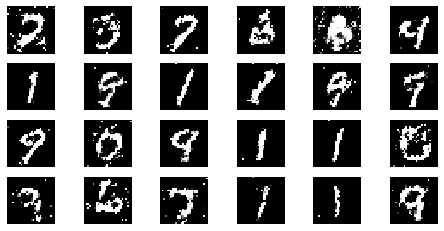

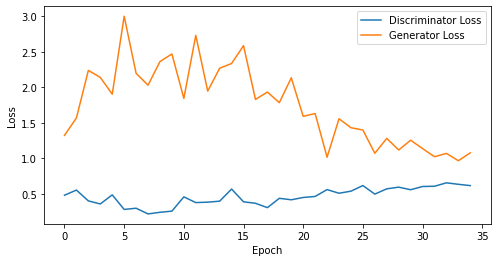

epoch: 35, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2.58772326 1.83111584 1.93426311
 1.78512692 2.13469982 1.59241939 1.63200712 1.01684582 1.55866873
 1.43240595 1.40002942 1.07261205 1.28229523 1.11896157 1.25640666
 1.13882589 1.02413833 1.07079339 0.96778113 1.07887995]
epoch :  35


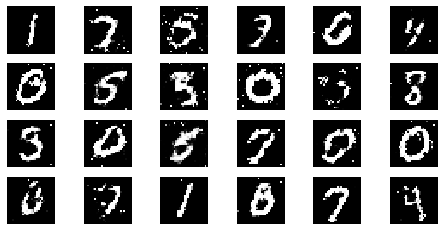

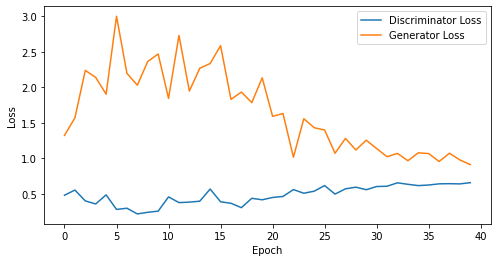

epoch: 40, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2.58772326 1.83111584 1.93426311
 1.78512692 2.13469982 1.59241939 1.63200712 1.01684582 1.55866873
 1.43240595 1.40002942 1.07261205 1.28229523 1.11896157 1.25640666
 1.13882589 1.02413833 1.07079339 0.96778113 1.07887995 1.06846333
 0.95736784 1.07326412 0.97848076 0.91275781]
epoch :  40


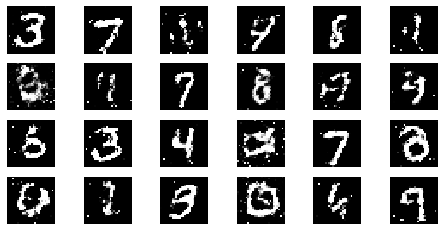

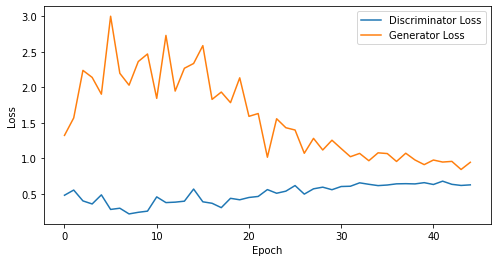

epoch: 45, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2.58772326 1.83111584 1.93426311
 1.78512692 2.13469982 1.59241939 1.63200712 1.01684582 1.55866873
 1.43240595 1.40002942 1.07261205 1.28229523 1.11896157 1.25640666
 1.13882589 1.02413833 1.07079339 0.96778113 1.07887995 1.06846333
 0.95736784 1.07326412 0.97848076 0.91275781 0

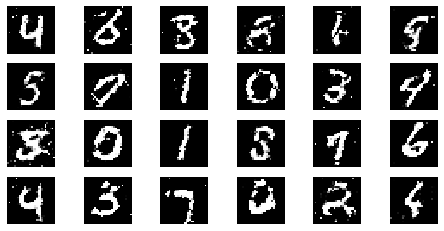

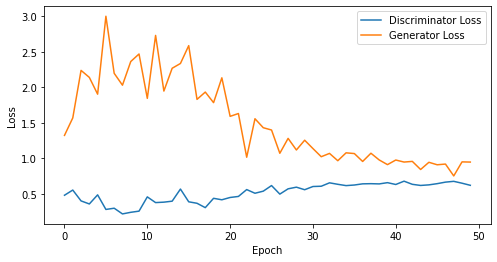

epoch: 50, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2.58772326 1.83111584 1.93426311
 1.78512692 2.13469982 1.59241939 1.63200712 1.01684582 1.55866873
 1.43240595 1.40002942 1.07261205 1.28229523 1.11896157 1.25640666
 1.13882589 1.02413833 1.07079339 0.96778113 1.07887995 1

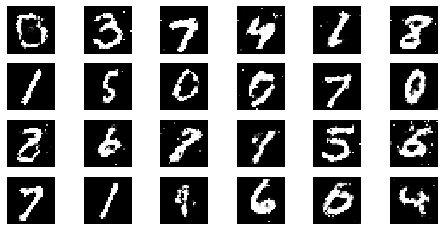

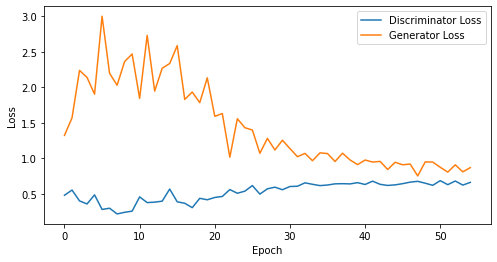

epoch: 55, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423 0.68692648 0.63063359 0.68226421 0.62467909
 0.66276145], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2.58772326 1.83111584 1.93426311
 1.78512692 2.13469982 1.59241939 1.63200712 1.01684582 1.55866873
 1.43240595 1.40002942 1.07261205 1.28229523 1.11896157 1.25640666
 

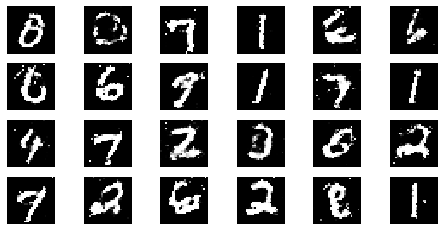

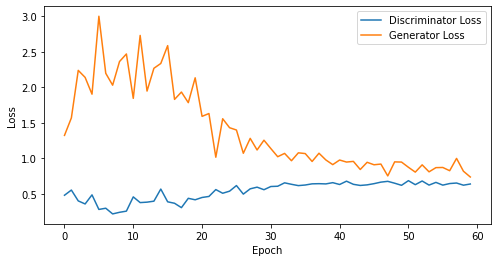

epoch: 60, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423 0.68692648 0.63063359 0.68226421 0.62467909
 0.66276145 0.62419248 0.64640558 0.65374893 0.62342787 0.64002299], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2.58772326 1.83111584 1.93426311
 1.78512692 2.13469982 1.59241939 1.63200712 1.01684582 1.55866873
 1.43240595 1

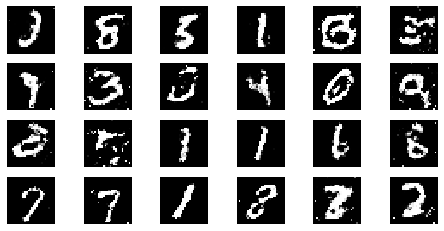

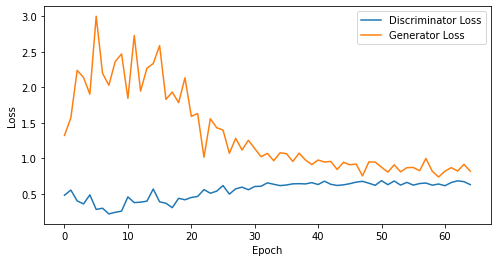

epoch: 65, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423 0.68692648 0.63063359 0.68226421 0.62467909
 0.66276145 0.62419248 0.64640558 0.65374893 0.62342787 0.64002299
 0.6160928  0.6608097  0.68494445 0.67272913 0.63123721], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2.58772326 1.83111584 1.93426311
 1.78512692 2.13469982 1

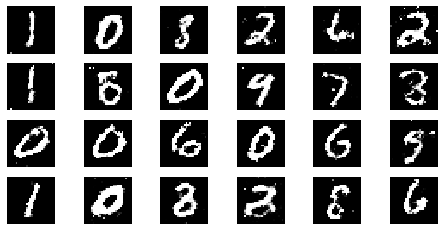

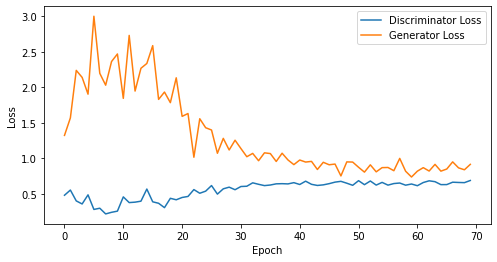

epoch: 70, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423 0.68692648 0.63063359 0.68226421 0.62467909
 0.66276145 0.62419248 0.64640558 0.65374893 0.62342787 0.64002299
 0.6160928  0.6608097  0.68494445 0.67272913 0.63123721 0.63182974
 0.66529608 0.66165513 0.65914202 0.68953615], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1.84562922 2.73153234
 1.94823539 2.26918697 2.33653975 2

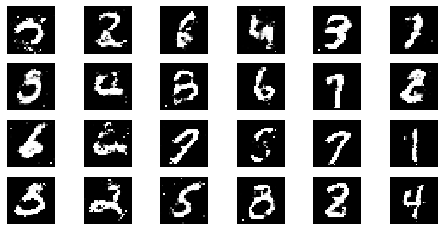

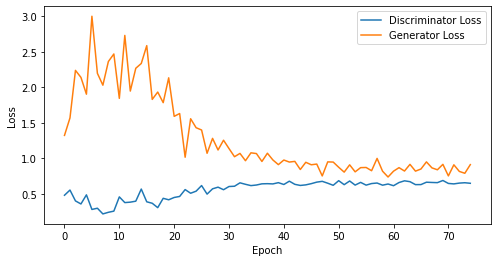

epoch: 75, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423 0.68692648 0.63063359 0.68226421 0.62467909
 0.66276145 0.62419248 0.64640558 0.65374893 0.62342787 0.64002299
 0.6160928  0.6608097  0.68494445 0.67272913 0.63123721 0.63182974
 0.66529608 0.66165513 0.65914202 0.68953615 0.6479786  0.64156049
 0.65276003 0.65776509 0.65008748], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3.00148535
 2.19816399 2.03102493 2.36389017 2.4702611  1

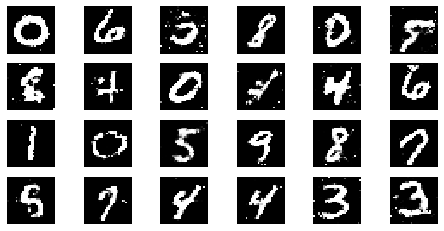

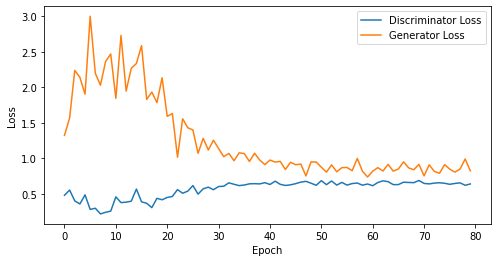

epoch: 80, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423 0.68692648 0.63063359 0.68226421 0.62467909
 0.66276145 0.62419248 0.64640558 0.65374893 0.62342787 0.64002299
 0.6160928  0.6608097  0.68494445 0.67272913 0.63123721 0.63182974
 0.66529608 0.66165513 0.65914202 0.68953615 0.6479786  0.64156049
 0.65276003 0.65776509 0.65008748 0.63589507 0.64794844 0.65616387
 0.62188256 0.64070135], Generator Loss: [1.32443953 1.57023609 2.23938656 2.14062476 1.90448928 3

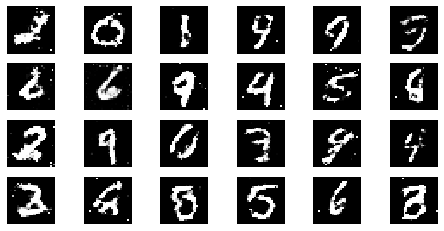

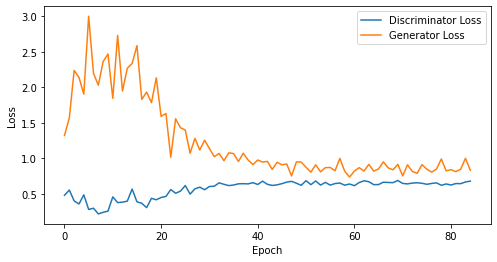

epoch: 85, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423 0.68692648 0.63063359 0.68226421 0.62467909
 0.66276145 0.62419248 0.64640558 0.65374893 0.62342787 0.64002299
 0.6160928  0.6608097  0.68494445 0.67272913 0.63123721 0.63182974
 0.66529608 0.66165513 0.65914202 0.68953615 0.6479786  0.64156049
 0.65276003 0.65776509 0.65008748 0.63589507 0.64794844 0.65616387
 0.62188256 0.64070135 0.62568337 0.64637715 0.64471066 0.66827399
 0.68068516], Generator Loss: [

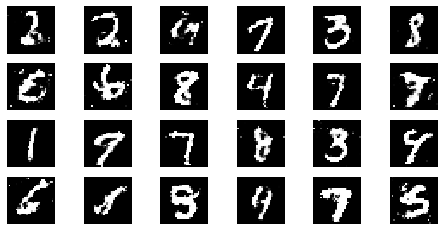

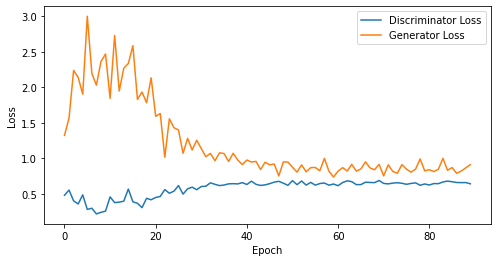

epoch: 90, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423 0.68692648 0.63063359 0.68226421 0.62467909
 0.66276145 0.62419248 0.64640558 0.65374893 0.62342787 0.64002299
 0.6160928  0.6608097  0.68494445 0.67272913 0.63123721 0.63182974
 0.66529608 0.66165513 0.65914202 0.68953615 0.6479786  0.64156049
 0.65276003 0.65776509 0.65008748 0.63589507 0.64794844 0.65616387
 0.62188256 0.64070135 0.62568337 0.64637715 0.64471066 0.66827399
 0.68068516 0.67199254 0.661236

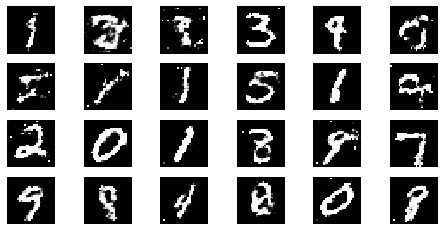

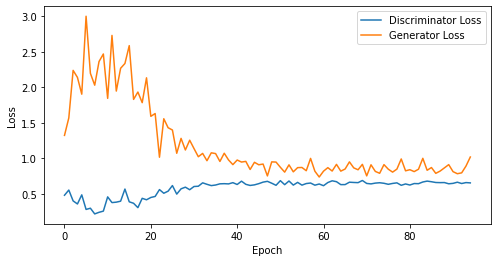

epoch: 95, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423 0.68692648 0.63063359 0.68226421 0.62467909
 0.66276145 0.62419248 0.64640558 0.65374893 0.62342787 0.64002299
 0.6160928  0.6608097  0.68494445 0.67272913 0.63123721 0.63182974
 0.66529608 0.66165513 0.65914202 0.68953615 0.6479786  0.64156049
 0.65276003 0.65776509 0.65008748 0.63589507 0.64794844 0.65616387
 0.62188256 0.64070135 0.62568337 0.64637715 0.64471066 0.66827399
 0.68068516 0.67199254 0.661236

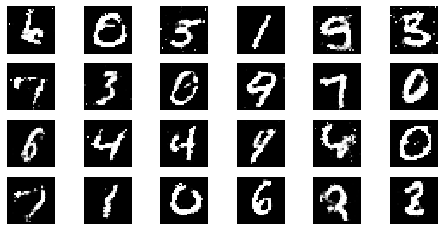

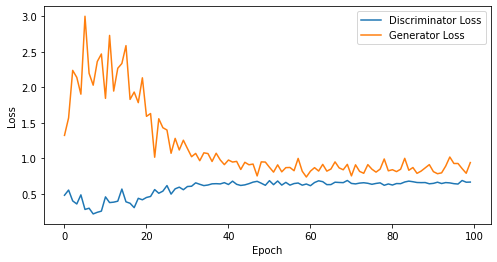

epoch: 100, Discriminator Loss: [0.48182121 0.55479026 0.40218624 0.35911888 0.48716938 0.28200012
 0.29910308 0.21896464 0.24160382 0.25812277 0.45871323 0.37838998
 0.38454211 0.39824581 0.56887668 0.38937891 0.36883849 0.30723023
 0.43858922 0.41791755 0.45042217 0.46487692 0.56144553 0.50989521
 0.53920931 0.61806089 0.49777642 0.57217079 0.595541   0.55955523
 0.60478991 0.60857087 0.65655011 0.6358282  0.61741656 0.62580878
 0.6423462  0.64458776 0.64137125 0.65889442 0.63316083 0.67983222
 0.63554192 0.61972779 0.62790298 0.64489102 0.66637814 0.67758083
 0.65123445 0.62171423 0.68692648 0.63063359 0.68226421 0.62467909
 0.66276145 0.62419248 0.64640558 0.65374893 0.62342787 0.64002299
 0.6160928  0.6608097  0.68494445 0.67272913 0.63123721 0.63182974
 0.66529608 0.66165513 0.65914202 0.68953615 0.6479786  0.64156049
 0.65276003 0.65776509 0.65008748 0.63589507 0.64794844 0.65616387
 0.62188256 0.64070135 0.62568337 0.64637715 0.64471066 0.66827399
 0.68068516 0.67199254 0.66123

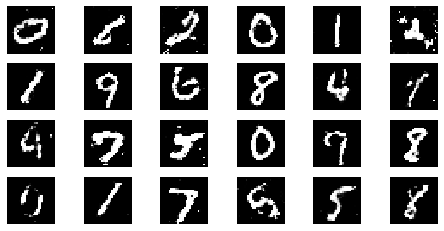

CPU times: user 32min 29s, sys: 1min 35s, total: 34min 5s
Wall time: 32min 48s


In [ ]:
%%time

EPOCHS = 100
BATCH_SIZE = 128

# discriminator, gan 'Loss' 저장 List
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # batch 별 학습
    for real_images in get_batches(X_train, BATCH_SIZE):
        # Noise 생성
        input_noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])

        # Fake image 데이터 생성
        generated_images = generator.predict(input_noise)

        # gan 학습 데이터 X 정의
        x_dis = np.concatenate([real_images, generated_images])

        # gan 학습 데이터 y 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 1

        # discriminator 학습
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)

        # gan 학습
        noise = np.random.uniform(-1, 1, size=[BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)

        # discriminator 학습 정지
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gan)
    
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)